<a href="https://colab.research.google.com/github/JunaidMovar/ML-DL-Learning/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
tf.config.run_functions_eagerly(True)
import time

In [78]:
tf.version.VERSION

'2.3.0'

In [79]:
(XTrain,YTrain),(XTest,YTest) = tf.keras.datasets.mnist.load_data()

In [80]:
def show_grid(col,row):
  f,s = plt.subplots(row,col,figsize=(col+1,row+1))
  for a in range(0,row):
    for b in range(0,col):
      s[a][b].imshow(XTrain[np.random.randint(0,60000)])
      s[a][b].set_xticks([])
      s[a][b].set_yticks([])
  f.show()

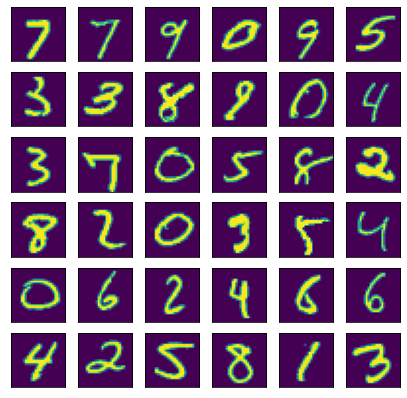

In [81]:
show_grid(6,6)

In [82]:
print(XTrain.shape)
XTrain = (XTrain - 127.5) / 127.5
Data = tf.data.Dataset.from_tensor_slices(XTrain.reshape(60000,28,28,1))
Data = Data.shuffle(60000).batch(256).cache().prefetch(tf.data.experimental.AUTOTUNE)

(60000, 28, 28)


# Generator
## What Is Generator 
###Generator Is Specialized Function Used To Generate Meaning From Image From Noise (Real Noise) 
###In Rough Words If We Try To Identify Generator Is Thief Who Wants To Crack Security Systems With Fake Identity Made By Randoms

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

In [84]:
def design_generator():
  model = Sequential([

       Dense(7*7*256,input_shape=(100,)),
       BatchNormalization(),
       LeakyReLU(),

       Reshape((7,7,256)),
       Conv2DTranspose(128,(5,5),strides=(2,2),padding='same'),
       BatchNormalization(),
       LeakyReLU(),

       Conv2DTranspose(64,(5,5),strides=(2,2),padding='same'),
       BatchNormalization(),
       LeakyReLU(),

       Conv2DTranspose(1,(5,5),padding='same')
     ])
  return model
  
Generator = design_generator()

In [85]:
generator_opt = Adam(1e-4)

cross_entropy = BinaryCrossentropy(from_logits=True)
@tf.function
def generator_loss(fake_pred):
  #fake_pred = tf.sigmoid(fake_pred)
  return cross_entropy(tf.ones_like(fake_pred),fake_pred)

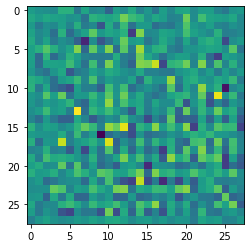

In [86]:
noise = np.random.randn(1,100)
Gen = np.array(Generator(noise)).reshape(28,28)
plt.imshow(Gen)

#Discriminator
##What Is Descriminator
###Discriminator Is Another NeuralNet Which Will Identify If Generator Is Generating Sensible Faces Or They Are Noisy
###In Rough Words Discriminator Is Police Officer Who Wish To Catch Thief(Here Generator) On Basis Of How Fake It Looks From Far Away

###Note : Here Our Task Is To Make Discriminaor Lose And Generator Win Because If Generator Will Fool Discriminator It Would Be Generating Beautiful Outputs For Us

In [87]:
def design_discriminator():
  model = Sequential([
                Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)),
                LeakyReLU(),
                Dropout(0.3),

                Conv2D(128,(5,5),strides=(2,2),padding='same'),
                LeakyReLU(),
                Dropout(0.3),
                
                Flatten(),
                
                Dense(50,activation='relu'),
                Dense(1)
  ])
  return model

Discriminator = design_discriminator()

In [88]:
discriminator_opt = Adam(1e-4)

@tf.function
def discriminator_loss(real_pred,fake_pred):
  #real_pred = tf.sigmoid(real_pred)
  #fake_pred = tf.sigmoid(fake_pred)
  real_loss = cross_entropy(tf.ones_like(real_pred),real_pred)
  fake_loss = cross_entropy(tf.zeros_like(fake_pred),fake_pred)
  return real_loss + fake_loss

In [93]:
def Train(Data,epochs):
  for _ in range(epochs):
    print(f'Epoch : {_}',end=' ')
    before = time.time()
    for images in Data:
      images = tf.cast(images,tf.float32)
      Train_step(images)
    after = time.time()
    print('Time Taken From Epoch ',after-before,' Seconds')

@tf.function
def Train_step(images):
  noise = np.random.randn(1,100).astype('float32')
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = Generator(noise)

    real_output = Discriminator(images)
    fake_output = Discriminator(generated_images)

    gen_loss = generator_loss(fake_pred=fake_output)
    dis_loss = discriminator_loss(real_output,fake_output)

    grad_gen = gen_tape.gradient(gen_loss,Generator.trainable_variables)
    grad_disc = dis_tape.gradient(dis_loss,Discriminator.trainable_variables)

    generator_opt.apply_gradients(zip(grad_gen,Generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(grad_disc,Discriminator.trainable_variables))
    #print('Generator Loss : ',np.mean(gen_loss),end=' ')
    #print(' Discriminator Loss : ',np.mean(dis_loss))
Train(Data,50)

Epoch : 0 Time Taken From Epoch  7.413566589355469  Seconds
Epoch : 1 Time Taken From Epoch  7.374554634094238  Seconds
Epoch : 2 Time Taken From Epoch  7.371837615966797  Seconds
Epoch : 3 Time Taken From Epoch  7.318063259124756  Seconds
Epoch : 4 Time Taken From Epoch  7.3284220695495605  Seconds
Epoch : 5 Time Taken From Epoch  7.281883001327515  Seconds
Epoch : 6 Time Taken From Epoch  7.308775186538696  Seconds
Epoch : 7 Time Taken From Epoch  7.272372722625732  Seconds
Epoch : 8 Time Taken From Epoch  7.26245379447937  Seconds
Epoch : 9 Time Taken From Epoch  7.335961818695068  Seconds
Epoch : 10 Time Taken From Epoch  7.28155779838562  Seconds
Epoch : 11 Time Taken From Epoch  7.297874689102173  Seconds
Epoch : 12 Time Taken From Epoch  7.300848960876465  Seconds
Epoch : 13 Time Taken From Epoch  7.3562257289886475  Seconds
Epoch : 14 Time Taken From Epoch  7.298657655715942  Seconds
Epoch : 15 Time Taken From Epoch  7.27045202255249  Seconds
Epoch : 16 Time Taken From Epoch  7

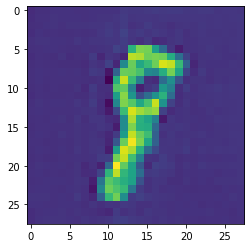

In [94]:
plt.imshow(np.array(Generator(np.random.randn(1,100))).reshape(28,28))

In [95]:
def show_generated_grid(col,row):
  f,s = plt.subplots(row,col,figsize=(col+1,row+1))
  for a in range(0,row):
    for b in range(0,col):
      s[a][b].imshow(np.array(Generator(np.random.randn(1,100))).reshape(28,28))
      s[a][b].set_xticks([])
      s[a][b].set_yticks([])
  f.show()

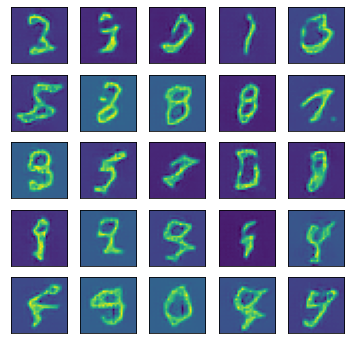

In [96]:
show_generated_grid(5,5)